In [1]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import random
import cv2
%matplotlib inline 


In [2]:
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.src.layers import Dense, Input, Dropout, Flatten, Conv2D,TimeDistributed
from keras.src.layers import BatchNormalization, Activation, MaxPooling2D,LSTM
from keras.src.models import Model, Sequential
from keras.src.optimizers import Adam
from keras.src.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.src.utils import plot_model


import tensorflow as tf

print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.16.1


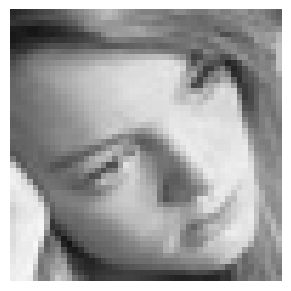

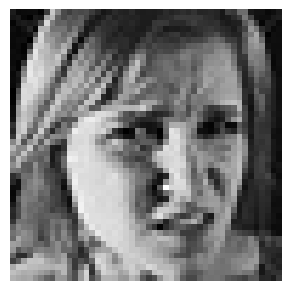

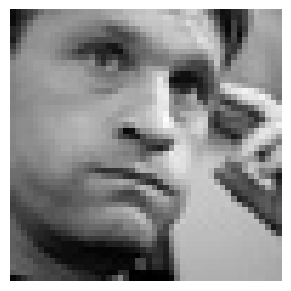

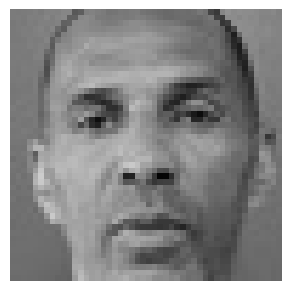

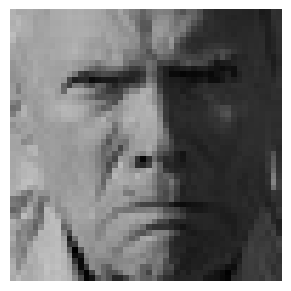

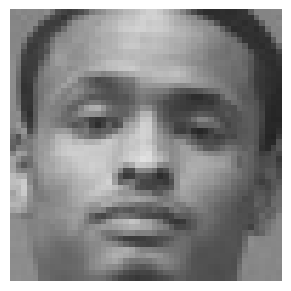

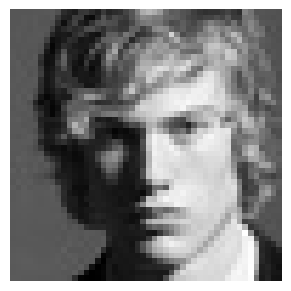

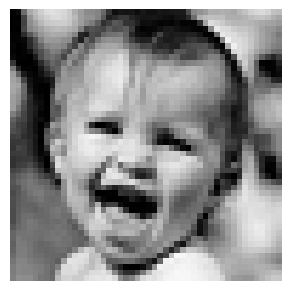

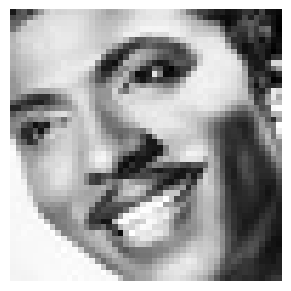

In [3]:
images = glob("train/**/**")
for i in range(9):
    image = random.choice(images)
    plt.figure(figsize=(12,12))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(image));plt.axis('off')

In [4]:
img_size = 48
batch_size = 64
sequence_length = 5
num_classes = 7

datagen_train = ImageDataGenerator(rescale=1./255,rotation_range=10,width_shift_range=0.1,
                                   height_shift_range=0.1,shear_range=0.1,zoom_range=0.1,
                                   horizontal_flip=True,fill_mode='nearest')
train_generator = datagen_train.flow_from_directory('train/',
                                                    target_size=(img_size,img_size),
                                                    color_mode='grayscale',
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)
datagen_validation = ImageDataGenerator(rescale=1./255)
validation_generator = datagen_validation.flow_from_directory('test/',
                                                              target_size=(img_size,img_size),
                                                              color_mode='grayscale',
                                                              batch_size=batch_size,
                                                              class_mode='categorical',
                                                              shuffle=True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [5]:
def generate_sequence_data(generator, sequence_length):
    while True:
        batch_x, batch_y = next(generator)
        sequence_x = []
        sequence_y = []
        for i in range(len(batch_x)-sequence_length+1):
            sequence_x.append(batch_x[i:i+sequence_length])
            sequence_y.append(batch_y[i+sequence_length-1])
        yield np.array(sequence_x), np.array(sequence_y)


In [6]:
train_sequence_generator = generate_sequence_data(train_generator,sequence_length)
validate_sequence_generator = generate_sequence_data(validation_generator,sequence_length)

In [7]:
def Convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters = filters, kernel_size = kernel_size, padding = "same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size = (2,2))(x)
    x = Dropout(0.25)(x)
    
    return x

In [8]:
def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)
    
    return x

In [9]:
def static_model(input_shape):
    inputs = Input(input_shape)
    conv_1 = Convolution(inputs,32,(3,3))
    conv_2 = Convolution(conv_1,64,(5,5))
    conv_3 = Convolution(conv_2,128,(3,3))

    flatten = Flatten()(conv_3)
    
    dense_1 = Dense_f(flatten,256)

    output  = Dense(7, activation="softmax")(dense_1)
    model  =  Model(inputs=[inputs],outputs = [output])
    
    model.compile(loss=['categorical_crossentropy'] , optimizer = 'adam' , metrics =["accuracy"])

    return model

In [10]:
def time_model(input_shape, sequence_length, num_classes):
    model = Sequential()
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'),
                              input_shape=(sequence_length,) + input_shape))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'),
                              input_shape=(sequence_length,) + input_shape))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))
    
    model.add(LSTM(256, return_sequences=False))
    
    model.add(Dense(512, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

In [12]:
Static_Model = static_model((48,48,1))
Static_Model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,309,063 (4.99 MB)

 Trainable params: 1,308,103 (4.99 MB)

 Non-trainable params: 960 (3.75 KB)

In [25]:
epochs = 10
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint("static_model_weights.weights.h5", monitor  ='val_accuracy', save_weights_only = True, mode = 'max', verbose =1)
callbacks = [checkpoint]

In [15]:
history_static = Static_Model.fit(
x = train_generator,
steps_per_epoch = steps_per_epoch,
epochs = epochs,
validation_data = validation_generator,
validation_steps = validation_steps,
callbacks = callbacks)

Epoch 1/10


c:\Users\SHAIK\.conda\envs\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2587 - loss: 1.9276
Epoch 1: saving model to static_model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 716s 2s/step - accuracy: 0.2588 - loss: 1.9273 - val_accuracy: 0.3013 - val_loss: 1.8270
Epoch 2/10
  1/448 ━━━━━━━━━━━━━━━━━━━━ 3:42 498ms/step - accuracy: 0.3125 - loss: 1.7631
Epoch 2: saving model to static_model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - accuracy: 0.3125 - loss: 1.7631 - val_accuracy: 0.3000 - val_loss: 1.8126
Epoch 3/10


c:\Users\SHAIK\.conda\envs\venv\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - accuracy: 0.3635 - loss: 1.6305
Epoch 3: saving model to static_model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 316s 704ms/step - accuracy: 0.3635 - loss: 1.6304 - val_accuracy: 0.4217 - val_loss: 1.5501
Epoch 4/10
  1/448 ━━━━━━━━━━━━━━━━━━━━ 4:04 548ms/step - accuracy: 0.3750 - loss: 1.6497
Epoch 4: saving model to static_model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 719us/step - accuracy: 0.3750 - loss: 1.6497 - val_accuracy: 0.4000 - val_loss: 1.5792
Epoch 5/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - accuracy: 0.4279 - loss: 1.4818
Epoch 5: saving model to static_model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 272s 604ms/step - accuracy: 0.4279 - loss: 1.4817 - val_accuracy: 0.4369 - val_loss: 1.4810
Epoch 6/10
  1/448 ━━━━━━━━━━━━━━━━━━━━ 3:25 459ms/step - accuracy: 0.4219 - loss: 1.4502
Epoch 6: saving model to static_model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 354us/step - accuracy: 0.4219 - lo

In [27]:
Static_Model.evaluate(validation_generator)

113/113 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 0.3814 - loss: 1.5170


[1.5351126194000244, 0.3757314085960388]

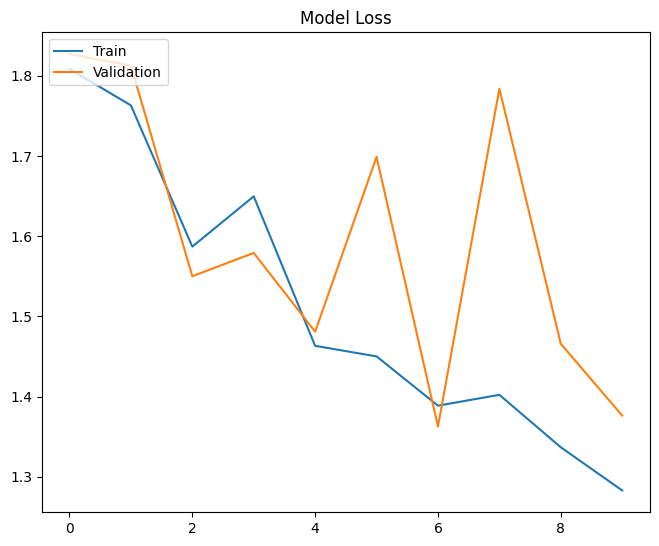

In [28]:
plt.plot(history_static.history['loss'])
plt.plot(history_static.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right =0.95,left=0.0,hspace=0.25,wspace=0.35)

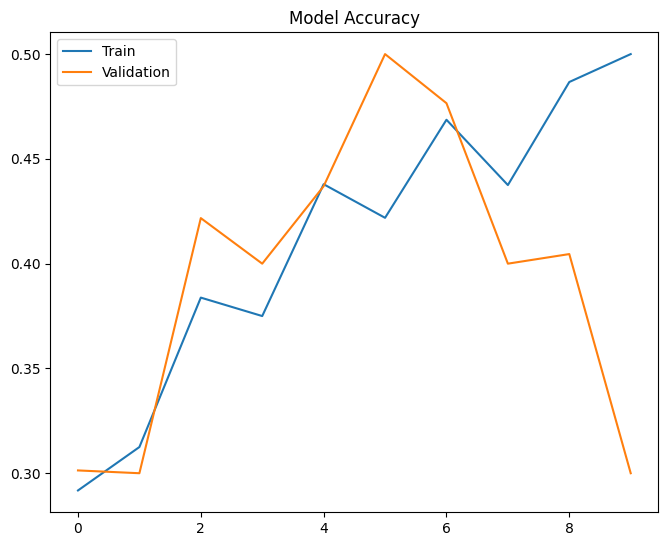

In [18]:
plt.plot(history_static.history['accuracy'])
plt.plot(history_static.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right =0.95,left=0.0,hspace=0.25,wspace=0.35)

In [29]:
model_json = Static_Model.to_json()
with open("static_model_a.json","w") as json_file:
    json_file.write(model_json)

In [30]:
input_shape = (img_size, img_size, 1)
Time_Model = time_model(input_shape, sequence_length, num_classes)
Time_Model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_16             │ (None, 5, 48, 48, 64)  │           640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_17             │ (None, 5, 24, 24, 64)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_18             │ (None, 5, 24, 24, 64)  │        36,928 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_19             │ (None, 5, 12, 12, 64)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_20             │ (None, 5, 9216)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 256)            │     9,700,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,873,095 (37.66 MB)

 Trainable params: 9,873,095 (37.66 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
epochs = 5  
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint("time_model_weights.weights.h5",monitor='val_accuracy',save_weights_only=True,mode='max',verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=1)
callbacks = [checkpoint, reduce_lr]


In [32]:
history_time = Time_Model.fit(train_sequence_generator,
                    steps_per_epoch = steps_per_epoch,
                    epochs = epochs,
                    validation_data = validate_sequence_generator,
                    validation_steps = validation_steps,
                    callbacks = callbacks) 

Epoch 1/5
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2430 - loss: 1.8096
Epoch 1: saving model to time_model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 1410s 3s/step - accuracy: 0.2431 - loss: 1.8095 - val_accuracy: 0.3629 - val_loss: 1.6441 - learning_rate: 0.0010
Epoch 2/5
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3364 - loss: 1.6627
Epoch 2: saving model to time_model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 1430s 3s/step - accuracy: 0.3364 - loss: 1.6626 - val_accuracy: 0.4160 - val_loss: 1.4947 - learning_rate: 0.0010
Epoch 3/5
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3814 - loss: 1.5680
Epoch 3: saving model to time_model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 1457s 3s/step - accuracy: 0.3814 - loss: 1.5680 - val_accuracy: 0.4514 - val_loss: 1.4073 - learning_rate: 0.0010
Epoch 4/5
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4240 - loss: 1.4762
Epoch 4: saving model to time_model_weights.weights.h5
448/448 ━━━━━━━

In [33]:
batch_size = 64
evaluation_steps = len(validation_generator)
evaluation_results = Time_Model.evaluate(validate_sequence_generator,steps = evaluation_steps,batch_size = batch_size)

113/113 ━━━━━━━━━━━━━━━━━━━━ 57s 505ms/step - accuracy: 0.4715 - loss: 1.3519


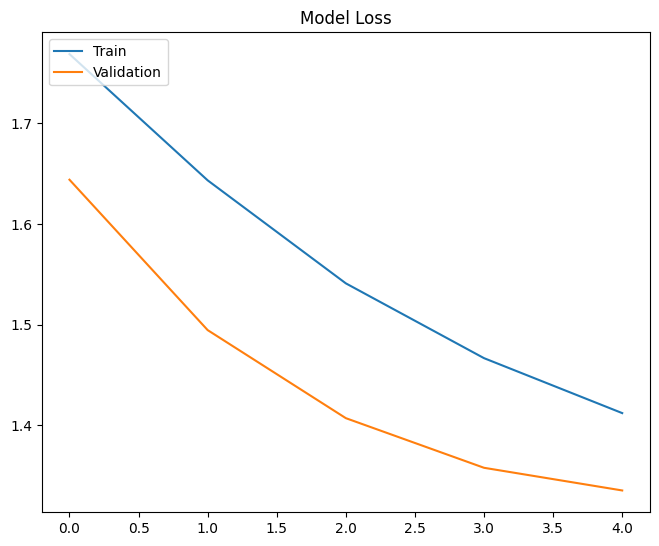

In [34]:
plt.plot(history_time.history['loss'])
plt.plot(history_time.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right =0.95,left=0.0,hspace=0.25,wspace=0.35)

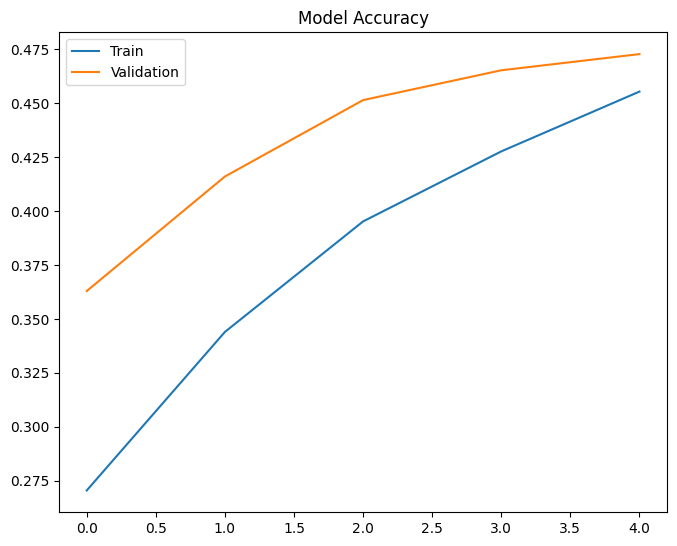

In [35]:
plt.plot(history_time.history['accuracy'])
plt.plot(history_time.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right =0.95,left=0.0,hspace=0.25,wspace=0.35)

In [36]:
model_json = Time_Model.to_json()
with open("time_model_a.json","w") as json_file:
    json_file.write(model_json)

In [37]:
plt.figure(figsize=(12, 5))

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

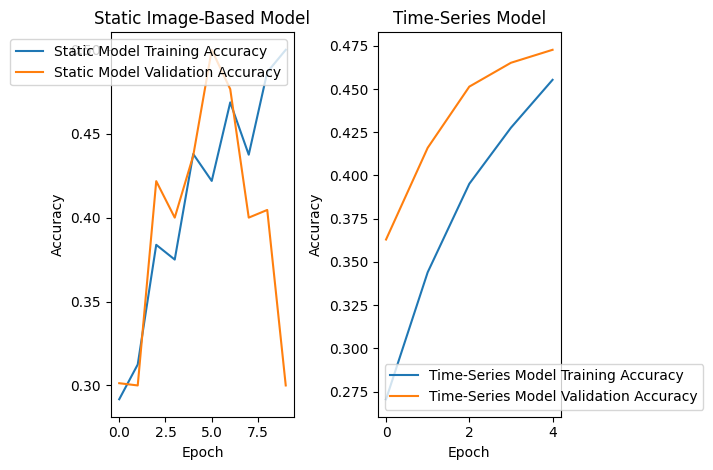

In [38]:
plt.subplot(1, 2, 1)
plt.plot(history_static.history['accuracy'], label='Static Model Training Accuracy')
plt.plot(history_static.history['val_accuracy'], label='Static Model Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Static Image-Based Model')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_time.history['accuracy'], label='Time-Series Model Training Accuracy')
plt.plot(history_time.history['val_accuracy'], label='Time-Series Model Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Time-Series Model')
plt.legend()

plt.tight_layout()
plt.show()